# 1. Ley de gravitación universal con ruido

A continuación, repetimos el experimento del cuadernillo anterior (**00_grav_law**) pero introduciendo ruido a la función que la red trata de aprender. Veamos el problema formalmente. Sean $D$ y $M$ variables aleatorias como las que introdujimos en el cuadernillo anterior. Sea $M_1, M_2 \sim M$ dos variables aleatorias independientes idénticamente distribuidas como $M$. Entonces, podemos describir la variable aleatoria $F$ como
$$
F = 2.773 \frac{M_1 M_2}{D^2}.
$$
El cuadernillo anterior trataba de aprender la relación entre $F$ y $M_1$, $M_2$ y $D$. Ahora definimos una nueva variable aleatoria $\hat{F}$ como
$$
\hat{F} = 2.773 \frac{M_1 M_2}{D^2} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2),
$$
es decir, introducimos un error normal centrado en el cero y con varianza $\sigma^2$. El objetivo será tratar de recuperar, de nuevo, la relación entre F y $M_1, M_2$ y $D$ para diferentes valores de $\sigma$.

Repetimos los mismo pasos que en el cuadernillo anterior. Solo se destacan los cambios más relevantes.

A continuación, creamos las funciones para crear los conjuntos de datos. El único cambio es que en el cálculo de $F$ introducimos un error normal.

In [1]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Genera una muestra de n observaciones de la variable aleatoria X
def dataset_point(n, r_min=1.295, r_max=5.0):
    u = torch.rand(n)
    r_cubed = u * (r_max**3 - r_min**3) + r_min**3
    r = r_cubed**(1/3)

    u_theta = torch.rand(n)
    u_phi = torch.rand(n)
    theta = torch.acos(1 - 2 * u_theta)
    phi = 2 * torch.pi * u_phi

    x = r * torch.sin(theta) * torch.cos(phi)
    y = r * torch.sin(theta) * torch.sin(phi)
    z = r * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Genera una muestra de n observaciones de la variable aleatoria D
def dataset_distance(n, r_min=1.3, r_max=5.0):
    points = dataset_point(2*n, r_min, r_max)
    p1 = points[:n]
    p2 = points[n:]
    return torch.norm(p1 - p2, dim=1)

# Genera una muestra de n observaciones de la variable aleatoria M
def dataset_mass(n, m_min=0.5, m_max=5.0, alpha=2.3):
    inv = 1.0 - alpha
    lower = m_min**inv
    upper = m_max**inv

    u = torch.rand(n)
    m = (lower + u*(upper - lower))**(1.0/inv)
    return m

def create_dataset(train_num=20000, test_num=10000, error=0.01):
    # Esta función genera un conjunto de datos (x,y) con una cantidad de datos menor a num (porque algunos se filtran)
    def generate_grav(num):
        # Generamos las distancias y filtramos
        d = dataset_distance(num, 1.295, 5)
        d = d[d > 1]

        # Generamos las masas una vez hemos filtrado
        new_num = len(d)
        m1 = dataset_mass(new_num)
        m2 = dataset_mass(new_num)

        # Calculamos el valor de F con un error normal
        G = 2.773
        F = G*(m1*m2)/(d**2) + error * torch.randn(new_num)

        x = torch.stack([m1, m2, d], dim=1)
        y = F.unsqueeze(dim=1)

        # Filtramos las valores de F muy pequeños
        mask = (y.squeeze() > 0.1)
        x = x[mask]
        y = y[mask]

        return x,y

    x_train, y_train = generate_grav(train_num)
    x_test, y_test = generate_grav(test_num)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

## $\sigma$ = 0.001

In [79]:
# Iniciamos la KAN
model = KAN(width=[3,5,1], grid=3, k=3, seed=2024, device=device);

dataset = create_dataset(error=0.001)

checkpoint directory created: ./model
saving model version 0.0


In [80]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 1.75e-01 | test_loss: 1.25e-01 | reg: 7.06e+00 | : 100%|█| 50/50 [00:13<00:00,  3.79it

saving model version 0.1


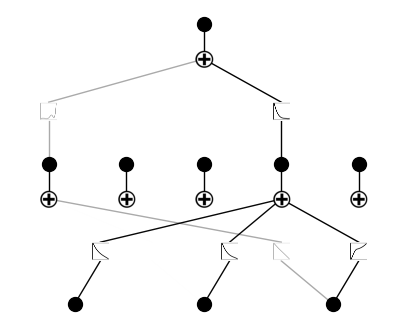

In [81]:
# Visualizamos la red
model.plot()

In [84]:
# Podamos la red
pruned_model = model.prune(node_th=2e-1, edge_th=2e-1)

saving model version 0.2


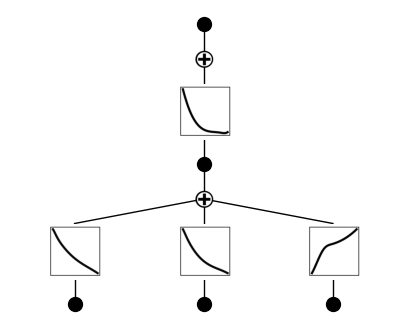

In [85]:
# Mostramos el modelo podado
pruned_model.plot()

Volvemos a entrenar el modelo, una vez realizada la poda.

In [86]:
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.66e-02 | test_loss: 1.84e-02 | reg: 8.12e+00 | : 100%|█| 100/100 [00:19<00:00,  5.07

saving model version 0.3


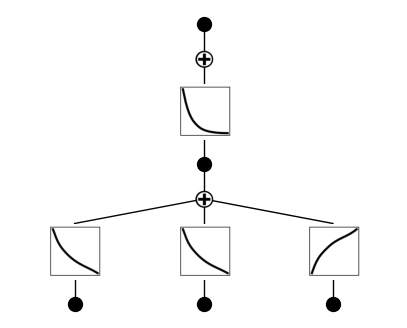

In [87]:
pruned_model.plot()

In [88]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999657 -11.466482           2                2   -0.693296
1    1/x^0.5    0.999571 -11.152791           2                2   -0.630558
2  1/sqrt(x)    0.999571 -11.152791           2                2   -0.630558
3        1/x    0.999267 -10.394084           2                2   -0.478817
4      1/x^2    0.998794  -9.683310           2                2   -0.336662
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999692 -11.618519           2                2   -0.723704
1    1/x^0.5    0.999658 -11.473067           2                2   -0.694613
2  1/sqrt(x)    0.999658 -11.473067           2                2   -0.694613
3        1/x    0.999382 -10.637402           2                2   -0.527480
4      1/x^2    0.998940  -9.868644           2                2   -0.373729
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

Podemos utilizar un razonamiento similar al del otro cuardernillo para elegir $\log$ en la primera capa y $\exp$ en la segunda.

In [89]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

r2 is 0.999656617641449
saving model version 0.4
r2 is 0.9996919631958008
saving model version 0.5
r2 is 0.9996917247772217
saving model version 0.6
r2 is 0.9998201131820679
saving model version 0.7


Volvemso a entrenar el modelo y vemos el resultado.

In [90]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.00e-03 | test_loss: 9.83e-04 | reg: 0.00e+00 | : 100%|█| 100/100 [00:07<00:00, 12.75

saving model version 0.8


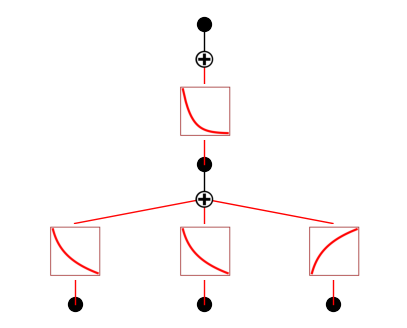

In [91]:
pruned_model.plot()

Como podemos ver, recuperamos casi correctamente la función buscada. Si esto fuera un experimento real, la fórmula es suficientemente buena como para poder intuir como es la fórmula original.

In [92]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.7728*x_1**1.0*x_2**1.0/x_3**2.0001

# $\sigma = 0.002$

In [95]:
# Iniciamos la KAN
model = KAN(width=[3,5,1], grid=3, k=3, seed=2024, device=device);

dataset = create_dataset(error=0.002)

checkpoint directory created: ./model
saving model version 0.0


In [96]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.02);

| train_loss: 1.58e-01 | test_loss: 1.18e-01 | reg: 6.76e+00 | : 100%|█| 50/50 [00:14<00:00,  3.53it

saving model version 0.1


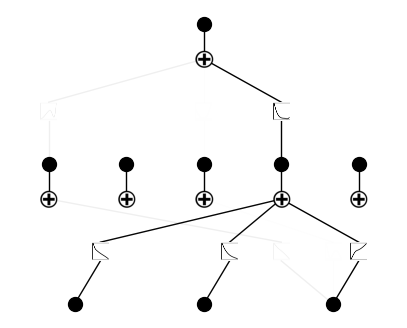

In [97]:
# Visualizamos la red
model.plot()

In [98]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


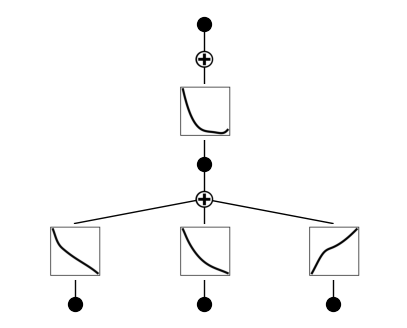

In [99]:
# Mostramos el modelo podado
pruned_model.plot()

In [100]:
# Volvemos a entrenar el modelo, tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.45e-02 | test_loss: 1.67e-02 | reg: 8.38e+00 | : 100%|█| 100/100 [00:19<00:00,  5.17

saving model version 0.3


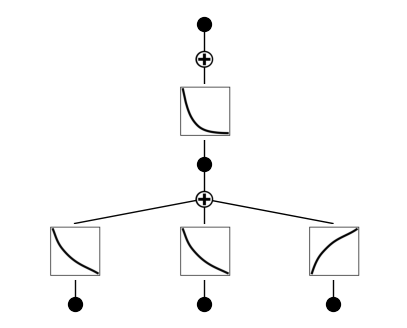

In [101]:
pruned_model.plot()

In [102]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999671 -11.525591           2                2   -0.705118
1    1/x^0.5    0.999556 -11.105794           2                2   -0.621159
2  1/sqrt(x)    0.999556 -11.105794           2                2   -0.621159
3        1/x    0.999237 -10.337468           2                2   -0.467494
4      1/x^2    0.998753  -9.635334           2                2   -0.327067
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999692 -11.619060           2                2   -0.723812
1    1/x^0.5    0.999602 -11.259424           2                2   -0.651885
2  1/sqrt(x)    0.999602 -11.259424           2                2   -0.651885
3        1/x    0.999298 -10.456633           2                2   -0.491327
4      1/x^2    0.998831  -9.728335           2                2   -0.345667
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

Volvemos a utilizar el mismo razonamiento del otro cuardernillo para elegir $\log$ en la primera capa y $\exp$ en la segunda.

In [103]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

Best value at boundary.
r2 is 0.9996708035469055
saving model version 0.4
r2 is 0.9996920824050903
saving model version 0.5
r2 is 0.9998013377189636
saving model version 0.6
r2 is 0.9998958110809326
saving model version 0.7


In [104]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 2.01e-03 | test_loss: 1.97e-03 | reg: 0.00e+00 | : 100%|█| 100/100 [00:09<00:00, 10.99

saving model version 0.8


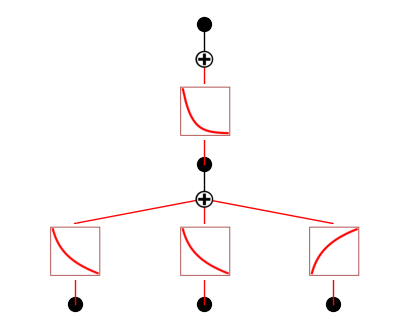

In [105]:
pruned_model.plot()

De nuevo, recuperamos una expresión que se parece mucho a la fórmula buscada.

In [106]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.773*(x_1 + 0.0004)**1.0003*(x_2 - 0.0003)**0.9999/(x_3 + 0.0001)**2.0003 + 0.0001

## $\sigma = 0.005$

In [29]:
# Iniciamos la KAN
model = KAN(width=[3,5,1], grid=3, k=3, seed=2025, device=device);

dataset = create_dataset(error=0.005)

checkpoint directory created: ./model
saving model version 0.0


In [30]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 3.10e-01 | test_loss: 1.96e-01 | reg: 5.98e+00 | : 100%|█| 50/50 [00:13<00:00,  3.75it

saving model version 0.1


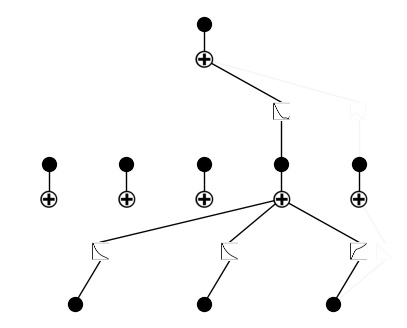

In [31]:
# Visualizamos la red
model.plot()

In [32]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


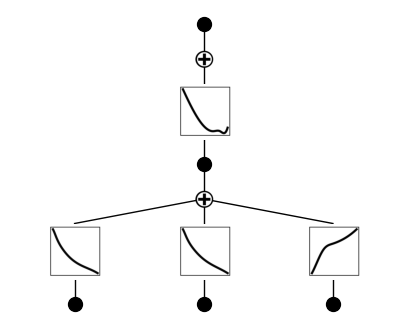

In [33]:
# Mostramos el modelo podado
pruned_model.plot()

In [34]:
# Volvemos a entrenar el modelo, tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.36e-02 | test_loss: 1.58e-02 | reg: 8.79e+00 | : 100%|█| 100/100 [00:19<00:00,  5.21

saving model version 0.3


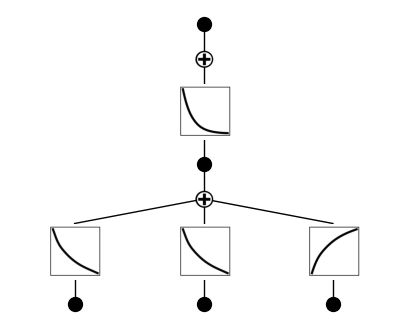

In [35]:
pruned_model.plot()

In [36]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999729 -11.795193           2                2   -0.759039
1    1/x^0.5    0.999557 -11.109209           2                2   -0.621842
2  1/sqrt(x)    0.999557 -11.109209           2                2   -0.621842
3        1/x    0.999217 -10.300669           2                2   -0.460134
4      1/x^2    0.998719  -9.596803           2                2   -0.319361
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999759 -11.957735           2                2   -0.791547
1    1/x^0.5    0.999619 -11.320570           2                2   -0.664114
2  1/sqrt(x)    0.999619 -11.320570           2                2   -0.664114
3        1/x    0.999307 -10.473406           2                2   -0.494681
4      1/x^2    0.998842  -9.742334           2                2   -0.348467
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

Volvemos a utilizar el mismo razonamiento del otro cuardernillo para elegir $\log$ en la primera capa y $\exp$ en la segunda.

In [37]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

r2 is 0.9997286200523376
saving model version 0.4
r2 is 0.9997586011886597
saving model version 0.5
r2 is 0.9998413920402527
saving model version 0.6
r2 is 0.9999620914459229
saving model version 0.7


In [38]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 5.05e-03 | test_loss: 5.00e-03 | reg: 0.00e+00 | : 100%|█| 100/100 [00:08<00:00, 11.42

saving model version 0.8


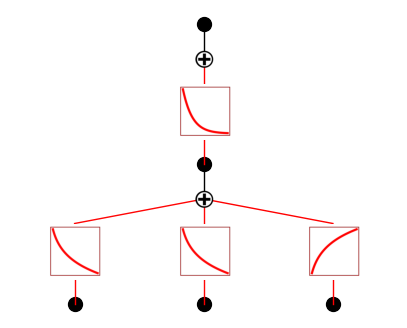

In [39]:
pruned_model.plot()

Como podemos ver la predicción vuelve a tener un cierto error, pero se puede deducir la estructura.

In [40]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.7703*(x_1 + 0.0004)**1.0003*(x_2 + 0.0002)**1.0004/(x_3 - 0.e-4)**2.0005 + 0.0004

# $\sigma = 0.01$

In [42]:
# Iniciamos la KAN
model = KAN(width=[3,5,1], grid=3, k=3, seed=2024, device=device);

dataset = create_dataset(error=0.01)

checkpoint directory created: ./model
saving model version 0.0


In [43]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 1.76e-01 | test_loss: 1.43e-01 | reg: 6.98e+00 | : 100%|█| 50/50 [00:13<00:00,  3.68it

saving model version 0.1


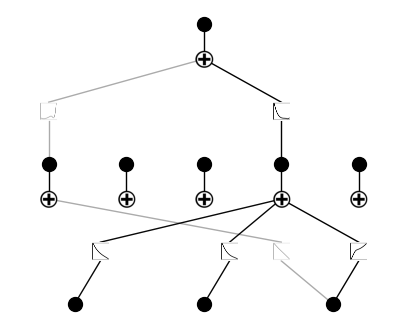

In [44]:
# Visualizamos la red
model.plot()

In [47]:
# Podamos la red
pruned_model = model.prune(node_th=2e-1, edge_th=2e-1)

saving model version 0.2


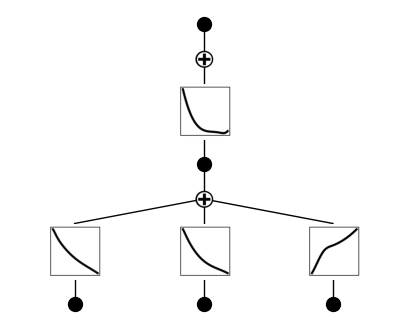

In [48]:
# Mostramos el modelo podado
pruned_model.plot()

In [49]:
# Volvemos a entrenar el modelo, tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.78e-02 | test_loss: 1.96e-02 | reg: 8.64e+00 | : 100%|█| 100/100 [00:19<00:00,  5.16

saving model version 0.3


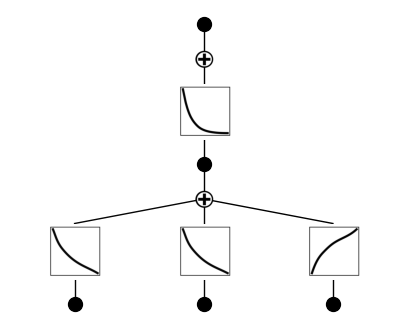

In [50]:
pruned_model.plot()

In [51]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999668 -11.512468           2                2   -0.702494
1    1/x^0.5    0.999541 -11.058444           2                2   -0.611689
2  1/sqrt(x)    0.999541 -11.058444           2                2   -0.611689
3        1/x    0.999214 -10.294500           2                2   -0.458900
4      1/x^2    0.998720  -9.598402           2                2   -0.319680
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999697 -11.643061           2                2   -0.728612
1    1/x^0.5    0.999623 -11.334271           2                2   -0.666854
2  1/sqrt(x)    0.999623 -11.334271           2                2   -0.666854
3        1/x    0.999326 -10.514451           2                2   -0.502890
4      1/x^2    0.998866  -9.771950           2                2   -0.354390
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

In [52]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

Best value at boundary.
r2 is 0.9996677041053772
saving model version 0.4
r2 is 0.9996973276138306
saving model version 0.5
r2 is 0.9995532035827637
saving model version 0.6
r2 is 0.9998555779457092
saving model version 0.7


In [53]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.00e-02 | test_loss: 9.84e-03 | reg: 0.00e+00 | : 100%|█| 100/100 [00:09<00:00, 11.01

saving model version 0.8


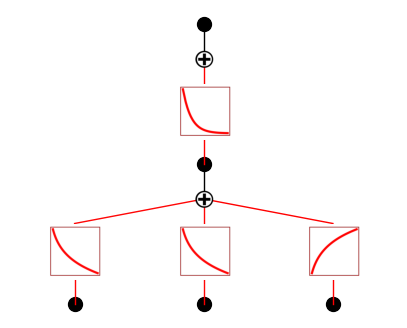

In [54]:
pruned_model.plot()

La aproximación obtenida es incluso peor que la que teníamos antes.

In [55]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.7842*(x_1 - 0.e-4)**1.0006*(x_2 - 0.0002)**1.0009/(x_3 + 0.0028)**2.005 + 0.0021

## $\sigma = 0.1$

In [56]:
# Iniciamos la KAN
model = KAN(width=[3,5,1], grid=3, k=3, seed=2025, device=device);

dataset = create_dataset(error=0.1)

checkpoint directory created: ./model
saving model version 0.0


In [57]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.02);

| train_loss: 1.68e-01 | test_loss: 1.50e-01 | reg: 6.97e+00 | : 100%|█| 50/50 [00:13<00:00,  3.72it

saving model version 0.1


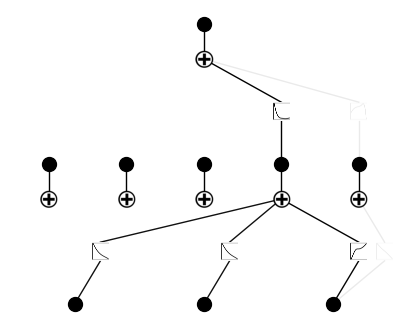

In [58]:
# Visualizamos la red
model.plot()

In [59]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


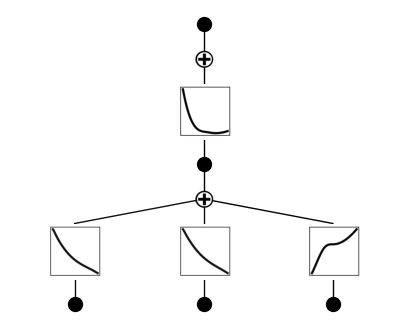

In [60]:
# Mostramos el modelo podado
pruned_model.plot()

In [61]:
# Volvemos a entrenar el modelo, tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 9.57e-02 | test_loss: 9.10e-02 | reg: 2.48e+01 | : 100%|█| 100/100 [00:20<00:00,  4.91

saving model version 0.3


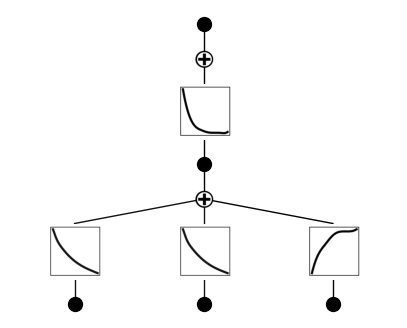

In [62]:
pruned_model.plot()

In [63]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999731 -11.809320           2                2   -0.761864
1    1/x^0.5    0.999456 -10.818883           2                2   -0.563777
2  1/sqrt(x)    0.999456 -10.818883           2                2   -0.563777
3        1/x    0.999143 -10.171589           2                2   -0.434318
4      1/x^2    0.998719  -9.597469           2                2   -0.319494
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999632 -11.370468           2                2   -0.674094
1    1/x^0.5    0.999210 -10.287927           2                2   -0.457585
2  1/sqrt(x)    0.999210 -10.287927           2                2   -0.457585
3        1/x    0.998800  -9.690824           2                2   -0.338165
4      1/x^2    0.998267  -9.164060           2                2   -0.232812
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0 

La función $(0,2,0)$ no tiene $\log$ como la primera opción. Sin embargo, vemos a continuación que la puntuación de $\log$ también es buena. Dado que la imagen no muestra carácter periódico descartamos $\cos$ y $\sin$. Por otro lado, dado que las otras dos funciones de la primera capa eran $\log$, es razonable probar con esta función.

In [64]:
pruned_model.fix_symbolic(0,2,0, 'log');

r2 is 0.98215252161026
saving model version 0.4


In [65]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

r2 is 0.9997313618659973
saving model version 0.5
r2 is 0.9996322989463806
saving model version 0.6
r2 is 0.9964436292648315
saving model version 0.7


In [66]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 8.59e-02 | test_loss: 8.38e-02 | reg: 0.00e+00 | : 100%|█| 100/100 [00:10<00:00,  9.96

saving model version 0.8


El error obtenido en este caso es más que considerable. A pesar de esto sigue siendo posible identificar la estructura de la función original.

In [67]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

3.1613*(x_1 + 0.0016)**1.0365*(x_2 - 0.034)**1.0156/(x_3 + 0.0753)**2.1717 + 0.0883